# Creating Customer Segments

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

Instructions:

- Run each code block below by pressing **Shift+Enter**, making sure to implement any steps marked with a TODO.
- Answer each question in the space provided by editing the blocks labeled "Answer:".
- When you are done, submit the completed notebook (.ipynb) with all code blocks executed, as well as a .pdf version (File > Download as).

In [21]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)
print data.head()  # print the first 5 rows

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


## Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

Answer:  The features that maximize variance might show up as the first PCA dimensions.  Let's calculate the variance of each feature.  

In [22]:
normalized_data = (data - data.mean()) / (data.max() - data.min())
var = normalized_data.var()
print var

Fresh               0.012718
Milk                0.010098
Grocery             0.010492
Frozen              0.006366
Detergents_Paper    0.013640
Delicatessen        0.003460
dtype: float64


After [normalizing](http://stackoverflow.com/a/12525836/7648) we can see that Detergents_Paper has the highest variance.  So Detergents_Paper will be the first principal component.  Let's now [compute the covariance of Detergents_Paper with the other features]((http://stackoverflow.com/a/32787030/7648)).

In [23]:
detergents_paper = 'Detergents_Paper'  
s = pd.Series({grocery_type: normalized_data[detergents_paper].cov(normalized_data[grocery_type]) 
               for grocery_type in normalized_data 
               if grocery_type != detergents_paper})
print s

Delicatessen    0.000476
Fresh          -0.001343
Frozen         -0.001226
Grocery         0.011061
Milk            0.007767
dtype: float64


Here we can see that Grocery has the most covariance with Detergents_Paper.  So Detergents_Paper and Grocery are probably the first two principal components.  I found the article ["Principal Component Analysis"](https://stat.ethz.ch/education/semesters/ss2012/ams/slides/v5.pdf) helpful in answering this. 

Linear combinations of the features will show up as ICA dimensions.  These new features will maximize independence.  Each feature in this new feature set will be some linear combination of Fresh, Milk, Grocery, Frozen, Detergents_Paper, and Delicatessen.

### PCA 

In [24]:
# Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA
pca = PCA(n_components=len(data.columns))
pca.fit(data)

# Print the components and the amount of variance in the data contained in each dimension
print pca.components_
print pca.explained_variance_ratio_

[[-0.97653685 -0.12118407 -0.06154039 -0.15236462  0.00705417 -0.06810471]
 [-0.11061386  0.51580216  0.76460638 -0.01872345  0.36535076  0.05707921]
 [-0.17855726  0.50988675 -0.27578088  0.71420037 -0.20440987  0.28321747]
 [-0.04187648 -0.64564047  0.37546049  0.64629232  0.14938013 -0.02039579]
 [ 0.015986    0.20323566 -0.1602915   0.22018612  0.20793016 -0.91707659]
 [-0.01576316  0.03349187  0.41093894 -0.01328898 -0.87128428 -0.26541687]]
[ 0.45961362  0.40517227  0.07003008  0.04402344  0.01502212  0.00613848]


**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

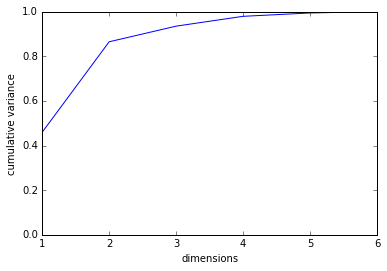

In [25]:
import matplotlib.pyplot as plt

x = np.arange(1, 7)
plt.plot(x, np.cumsum(pca.explained_variance_ratio_), '-')
plt.xlabel('dimensions')
plt.ylabel('cumulative variance')
plt.ylim([0.0, 1.0])
plt.show()

Answer: We can see how the cumulative sum of the variance approaches 1.0 in the plot above.  If i were to use PCA on this dataset, I would choose 3 dimensions for my dimensions.  After 3 dimensions, the change in variance is less steep.

**3)** What do the dimensions seem to represent? How can you use this information?

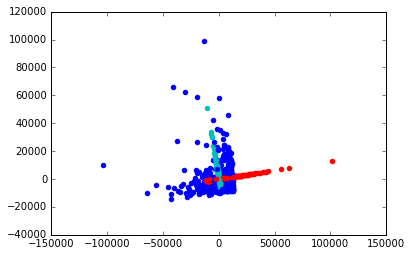

In [26]:
first_pc = pca.components_[0]
second_pc = pca.components_[1]

transformed_data = pca.transform(data)
plt.close()
for ii in transformed_data:
    plt.scatter(first_pc[0]*ii[0], first_pc[1]*ii[0], color="r")
    plt.scatter(second_pc[0]*ii[1], second_pc[1]*ii[1], color="c")
    plt.scatter(ii[0], ii[1], color="b")
    
plt.show()

Answer: The dimensions seem to represent the features.  We can use this information to find out which features are most useful in classifying data points.  Looking at the first two components (in red and cyan), we can see that they are orthogonal.  Let's look at the actual value of the first component:

In [28]:
print first_pc

[-0.97653685 -0.12118407 -0.06154039 -0.15236462  0.00705417 -0.06810471]


From these values, we can see that the first entry has the largest absolute value, and, thus, that Fresh dominates the first component.  Let's look at the second component:

In [29]:
print second_pc

[-0.11061386  0.51580216  0.76460638 -0.01872345  0.36535076  0.05707921]


Grocery and Milk (in that order) dominate the second component.  Hence, the distributor knows that the amount of Fresh, Grocery, and Milk that a store orders is what differentiates that store from other stores.  If two stores buy about the same amount of Fresh, then the distributor knows that the two stores will likely react the same to different changes in distribution policy.

### ICA

In [10]:
# Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!
data_scaled = preprocessing.scale(data)

from sklearn.decomposition import FastICA
ica = FastICA()
ica.fit(data_scaled)

# Print the independent components
print ica.components_

[[-0.0048949  -0.00155491 -0.00561549 -0.00254501  0.00238935  0.05093904]
 [-0.05025832  0.00642593  0.00711213  0.00322074 -0.01111118  0.002774  ]
 [-0.00347637  0.01868013  0.1092834  -0.0072229  -0.13346057 -0.01606215]
 [-0.0024791   0.0127213  -0.06882174 -0.00145547  0.01315833  0.00528139]
 [-0.00194383 -0.07237771  0.05633054  0.00166814 -0.01726082  0.0169436 ]
 [-0.01092779 -0.00107241  0.00732638  0.0540558  -0.00255465 -0.01674272]]


**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

Answer: Each vector corresponds to a linear combination of features.  These components, or transformed features, identify fundamental features of your data that can be used for classification.  The primary feature affected by each of the first four vectors, respectively, is:

* Delicatessen.  All other elements in the vector are about an order of magnitude less and thus have much less effect.
* Fresh.  Detergents_Paper is secondary and both have the same sign.  This would would suggest that, independent of other effects, there is a correlation between Fresh and Detergents_Paper purchases.
* Detergents_Paper.  Grocery is secondary and has a positive value compared to the negative value of Detergents_Paper.  This would would suggest that, independent of other effects, there is an anti-correlation between Detergents_Paper and Grocery purchases.
* Grocery.  Detergents_Paper is secondary and has a positive value compared to the negative value of Grocery.  This would would suggest that, independent of other effects, there is an anti-correlation between Detergents_Paper and Grocery purchases.  This is consistent with the third vector.

Our observable variables are the sales figures for each type of product for many stores.  The hidden variables are different types of customers.  ICA attempts to separate out these hidden variables from the observables.  Each of the vectors contributes to this.  The first vector helps separate into different types of customers mostly based on Delicatessen sales.  The second vector based mostly on Fresh and Detergents_Paper sales.  The third and fourth vectors based on the relationship between Detergents_Paper and Grocery sales.

## Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

### Choose a Cluster Type

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

Answer: k-means creates 'hard' boundaries between the clusters.  That is, each data point belongs to exactly one cluster.  On the other hand, Gaussian mixture models create 'soft' boundaries.  That is, each data point belongs to a given cluster with a certain probability.

* k-means clustering advantages 
    - [Cheap](http://stats.stackexchange.com/a/58857) relative to other unsupervised learning algorithms  
    - [Scales well](http://scikit-learn.org/stable/modules/clustering.html#k-means)
* [Gaussian mixture models advantages](http://scikit-learn.org/stable/modules/mixture.html#pros)
    - Fastest mixture model algorithm
    - No bias of the means towards zero
    
Let's use a Gaussian mixture model.

**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [30]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [31]:
# First we reduce the data to two dimensions using PCA to capture variation
reduced_data = PCA(n_components=2).fit_transform(data)
print reduced_data[:10]  # print upto 10 elements

[[  -650.02212207   1585.51909007]
 [  4426.80497937   4042.45150884]
 [  4841.9987068    2578.762176  ]
 [  -990.34643689  -6279.80599663]
 [-10657.99873116  -2159.72581518]
 [  2765.96159271   -959.87072713]
 [   715.55089221  -2013.00226567]
 [  4474.58366697   1429.49697204]
 [  6712.09539718  -2205.90915598]
 [  4823.63435407  13480.55920489]]


In [32]:
def create_clusters(reduced_data, n_clusters):
    # Implement your clustering algorithm here, and fit it to the reduced data for visualization

    gmm = GMM(n_clusters)
    gmm.fit(reduced_data)
    bic = gmm.bic(reduced_data)
    print "BIC: {}\n".format(bic)
    
    return gmm

# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

def obtain_labels(clusters, xx, yy):
    # Obtain labels for each point in mesh. Use last trained model.
    Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])
    
    return Z

def find_means(clusters):
    # Find the centroids for KMeans or the cluster means for GMM 
    means = clusters.means_
    
    return means

def show_plot(reduced_data, means, xx, yy, Z):
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    plt.scatter(means[:, 0], means[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

In [33]:
def visualize_cluster_data(n_clusters):
    # The visualizer below assumes your clustering object is named 'clusters'
    clusters = create_clusters(reduced_data, n_clusters)
    print 'clusters:\n{}\n'.format(clusters)

    Z = obtain_labels(clusters, xx, yy)

    means = find_means(clusters)
    print 'means:\n{}\n'.format(means)

    show_plot(reduced_data, means, xx, yy, Z)
    
    return clusters

Answer: First let's try 8 clusters.

BIC: 18332.5211418

clusters:
GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=8, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)

means:
[[   2829.9507428    14659.30660227]
 [   -151.12360792   -7714.15800489]
 [   7566.60307177   -5577.10124456]
 [ -19499.79783393   45528.05468009]
 [-103863.42532004    9910.34962857]
 [ -26977.30325995   -8460.87224652]
 [  -5330.40325537   -1117.39324151]
 [   9430.79357562    5260.69348816]]



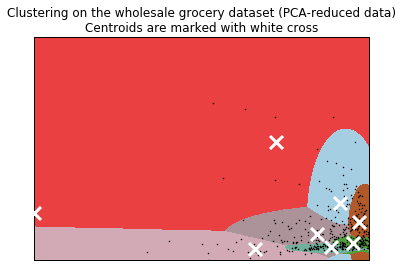

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=8, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)

In [34]:
visualize_cluster_data(8)

Everything is pretty scrunched together in the lower right.  Let's try 4 clusters.

BIC: 18430.3971352

clusters:
GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=4, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)

means:
[[  7174.54719282   5469.02876453]
 [  2339.15204219  -6708.93065712]
 [-15372.37194307  -3334.43379857]
 [ -9486.9742574   34645.20428228]]



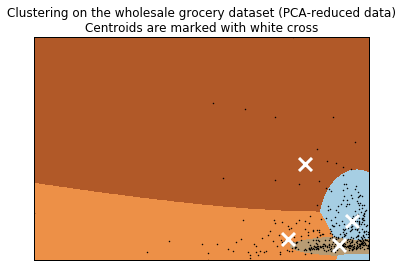

In [35]:
gmm = visualize_cluster_data(4)

That clustering looks better.  However, notice that they have pretty close BIC scores.  I especially like the way the tan cluster separates out the elongated set of customers.  You wouldn't be able to capture that as tightly with k-means.

Let's sample 3 data points from each of the 4 clusters.  We will try to find intra-cluster similarities and inter-cluster differences.

In [36]:
Z = gmm.predict(reduced_data)
def get_sample(Z, label):
    cluster_indices = np.where(Z == label)[0]
    cluster_indices = np.random.choice(cluster_indices, size=3, replace=False)
    indices = cluster_indices.tolist()
    indices.sort()
    
    return data.iloc[indices, :]
    
for i in range(4):
    print "Cluster {}:\n{}\n".format(i, get_sample(Z, i))

Cluster 0:
     Fresh   Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
94    5626  12220    11323     206              5038           244
272    514   8323     6869     529                93          1040
297   8090   3199     6986    1455              3712           531

Cluster 1:
     Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
307  17327  2374     2842    1149               351           925
322  15881   713     3315    3703              1470           229
375   5841  1450     1162     597               476            70

Cluster 2:
     Fresh   Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
282  49063   3965     4252    5970              1041          1404
373  15076   6257     7398    1504              1916          3113
427  31012  16687     5429   15082               439          1163

Cluster 3:
     Fresh   Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
211  12119  28326    39694    4736             19410          2870
251   6134  23133  

I find it a little hard to distinguish exactly what is going on from looking at these samples.  Also, I tend to be skeptical whether a sample of 3 from each cluster is large enough to draw conclusions.  Let's look at the mean and variance of all the data points in each cluster.

In [38]:
def get_pop(Z, label):
    cluster_indices = np.where(Z == label)[0]
    indices = cluster_indices.tolist()
    
    return data.iloc[indices, :]
    
for i in range(4):
    pop = get_pop(Z, i)
    mean = pop.mean()
    print "Cluster {} mean:".format(i)
    print mean
    print

Cluster 0 mean:
Fresh                4393.328671
Milk                 8573.510490
Grocery             12364.937063
Frozen               1803.139860
Detergents_Paper     5123.552448
Delicatessen         1423.433566
dtype: float64

Cluster 1 mean:
Fresh               10142.481132
Milk                 2133.806604
Grocery              2548.066038
Frozen               3065.603774
Detergents_Paper      506.438679
Delicatessen          959.080189
dtype: float64

Cluster 2 mean:
Fresh               32527.764706
Milk                 5569.102941
Grocery              7539.838235
Frozen               5378.044118
Detergents_Paper     1685.500000
Delicatessen         2350.205882
dtype: float64

Cluster 3 mean:
Fresh               17046.529412
Milk                29016.411765
Grocery             39851.588235
Frozen               4599.176471
Detergents_Paper    18424.117647
Delicatessen         6132.529412
dtype: float64



Cluster 0 seems to represent small grocery stores.  Note that it sells more groceries than other types of products, but it does not sell as many groceries as, say, Cluster 3.

Cluster 1 sells a lot fresh food compared to other types of products, but does not sell as much fresh food as Cluster 2 or Cluster 3.  I would venture to guess that Cluster 1 contains organic food co-ops.

Cluster 2 is similar to Cluster 1, but bigger.  I would guess that it might contain organic chain stores, such as Whole Foods or Trader Joe's.

Finally, stores in Cluster 3 sell a lot of everything.  I would guess that this cluster contains mostly chain supermarkets, such as Cub Foods or Safeway.

**7)** What are the central objects in each cluster? Describe them as customers.

Answer: The central objects in each cluster are the centroids.  You can think of them as an average customer within that cluster.

### Conclusions

** 8)** Which of these techniques did you feel gave you the most insight into the data?

Answer: *Plotting* the output of the Gaussian mixture models algorithm gave me the most insight into the data.  I think plots always give you more insight than raw numbers or tables.  I think GMM worked best here because the all the features are continuous and the distributions of the features are probably Gaussian.  You can see this in the plots (although there are long tails going to the left and up in the plots).  GMM with four clusters nicely differentiated the data (especially in the elongated, tan cluster).  I actually first tried k-means but the clusters seemed much more random.

**9)** How would you use that technique to help the company design new experiments?

Answer: When conducting a new experiment on a possible change, I would use four small samples of customers with one sample drawn from each cluster.  With these four samples, I could see how each of the four clusters would react to the change.  From those results, I could generalize to the clusters as a whole.  If the sample from a cluster liked the change, I could implement the change for all members of the cluster.

For example, consider our original problem of changing from a regular morning delivery to a cheaper, bulk evening delivery.  The highest volume customers had an easy time adapting to the change, whereas smaller, family-run shops had serious issues with it.  It would have made sense to try the change in delivery time with a sample from each cluster.  If the change went well for the sample from a particular cluster, it would make sense to consider implementing the change for all the members of that cluster.  Similarly, If the change didn't go well for the sample from a particular cluster, it would make sense to not implement the change for the members of that cluster.

**10)** How would you use that data to help you predict future customer needs?

Answer: Every time we get a new customer, we could have the GMM model label the customer.  We would then know that customer policies, such as delivery times, that worked well with the current customers with that label would probably also work well with the new customer.  Similarly, customer policies that didn't work well with the current customers with that label would probably also not work well with the new customer.